<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/05_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('bootstrap_homework.csv')

## Задание 1. Изучение распределений в группах(1/4) ##
Для начала давайте просто взглянем на квантили распределения в обеих группах.

Найдите 0.7 квантиль распределения revenue для группы 0.

In [ ]:
data.groupby('group').revenue.quantile(0.7)[0]

960.0

## Задание 1. Изучение распределений в группах (2/4) ##
Найдите 0.7 квантиль распределения revenue для группы 1.

In [ ]:
data.groupby('group').revenue.quantile(0.7)[1]

1128.0

## Задание 1. Изучение распределений в группах (3/4) ##
Также полезно посмотреть, изменились ли меры разброса. Давайте посмотрим межквартильный размах. Межквартильный размах — разница между 1-ым квартилем (0.25) и 3-им квартилем (0.75) распределения.

Найдите межквартильный размах для группы 0.

In [ ]:
data.groupby('group').revenue.agg(lambda x: x.quantile(0.75) - x.quantile(0.25))[0]

963.0

## Задание 1. Изучение распределений в группах (4/4) ##
Найдите межквартильный размах для группы 1.

In [ ]:
data.groupby('group').revenue.agg(lambda x: x.quantile(0.75) - x.quantile(0.25))[1]

1186.0

## Задание 2. Проверка гипотезы бутстрапом (1/5) ##
Для начала давайте проверим с помощью бутстрапа один квантиль распределения.

С помощью бутстрапа проверьте гипотезу о равенстве 0.8 квантиля распределений между двумя группами. Альфа = 0.05. Перед стартом первой итерации бутстрапа установите np.random.seed(1). Кол-во итераций бутстрапа = 10000. Отклоняется ли гипотеза H0 о равенстве квантилей распределения?

In [ ]:
def ab_bootsrtap(sample_a, sample_b, alpha=0.05, n_iters=10000, quantile=None, test_func=np.mean, seed=None):
  # функия вычисляет p-value для заданных выборок при помощи bootstrap
  if seed:
    np.random.seed(seed)
  # из каждой исходной выборки берем n_iters повтроных выборок с повторением
  samples_a = np.random.choice(sample_a,  size = (n_iters, len(sample_a)), replace=True)
  samples_b = np.random.choice(sample_b,  size = (n_iters, len(sample_b)), replace=True)
  # считаем статистику для каждой выборки
  # если задан квантиль, то его и считаем
  if quantile:
    resample_stats_A = np.array([np.quantile(a, quantile) for a in samples_a])
    resample_stats_B = np.array([np.quantile(b, quantile) for b in samples_b])
    samples_diff = np.quantile(sample_b, quantile) - np.quantile(sample_a, quantile)
  # если кваниль не задан, то вычисляем значениея с помощью test_func
  else:
    resample_stats_A = np.array([test_func(a) for a in samples_a])
    resample_stats_B = np.array([test_func(b) for b in samples_b])
    samples_diff = test_func(sample_b) - test_func(sample_a)

  resampled_diffs = resample_stats_B - resample_stats_A

  # вычитаем разницу статистик в первоначальной выборке, чтобы получить resampled_diffs как бы для AA
  # (учитываем разницу в исходной выборки и убираем это смещение)
  adjusted_resampled_diff = (abs(resampled_diffs - samples_diff))
  # проверяем, как часто разница статистик в после компенсации смещения была больше, чем первоначальная
  p_value = np.mean(abs(adjusted_resampled_diff) >= abs(samples_diff))
  # доверительный интервал
  perc_ci = np.quantile(resampled_diffs, [alpha/2, 1-alpha/2])
  return {'p_value': p_value, 'conf_int': perc_ci, 'resampled_diffs': resampled_diffs}

In [ ]:
a = data.query('group == 0').revenue
b = data.query('group == 1').revenue
seed = 1
ab_bootsrtap(a, b, quantile=0.8, seed=1) # разница статистически не значима

{'p_value': 0.1804, 'conf_int': array([-15., 120.])}

## Задание 2. Проверка гипотезы бутстрапом (2/5) ##
Укажите полученное с помощью бутстрапа p_value.

Введите ответ в поле ниже с точностью до четырех знаков в десятичной части.

In [ ]:
ab_bootsrtap(a, b, quantile=0.8, seed=1)['p_value']

0.1804

## Задание 2. Проверка гипотезы бутстрапом (3/5) ##
С помощью бутстрапа проверьте гипотезу о равенстве 0.4 квантиля распределениий между двумя группами. Альфа = 0.05. Перед стартом первой иттерации бутстрапа установите np.random.seed(1). Кол-во итераций бутстрапа = 10000. Отклоняется ли гипотеза H0 о равенстве квантилей распределения?

In [ ]:
ab_bootsrtap(a, b, quantile=0.4, seed=1)['p_value']
# разница статистически значима

0.0

## Задание 2. Проверка гипотезы бутстрапом (4/5) ##
Укажите среднее разниц квантилей, полученное с помощью бутстрапа на предыдущем степе.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
f"среднее разниц квантилей= {ab_bootsrtap(a, b, quantile=0.4, seed=1)['resampled_diffs'].mean():.1f}"

'среднее разниц квантилей= -56.1'

## Задание 2. Проверка гипотезы бутстрапом (5/5) ##
С помощью бутстрапа проверьте гипотезу о равенстве 0.65 квантиля распределений между двумя группами. Альфа = 0.05. Перед стартом первой итерации бутстрапа установите np.random.seed(1). Кол-во итераций бутстрапа = 10000. Укажите p-value, полученное в этой проверке.

Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
ab_bootsrtap(a, b, quantile=0.65, seed=1)['p_value']

0.0

## Задание 3. Децильный анализ (1/4) ##
Разовые проверки квантилей распределения показывают, что эффекты неоднородные, влияние на выборку 1 после изменения цен явно имело фрагментарный и неодинаковый характер. Давайте проведем децильный анализ, т.е. поищем эффекты во всем пространстве децилей распределения.

Определите с помощью бутстрапа, с какого перцентиля распределения начинает детектится эффект на revenue.

Стартуем симуляции с 0.01 перцентиля.
Шаг перебора перцентилей в симуляциях 0.01
Перед стартом перебора установите np.random.seed(1)
Для каждой итерации перебора используйте следующую конфигурацию бутстрапа:

альфа = 0.05
кол-во итераций внутри бутстрапа = 2000
поправка на множественные сравнения - Бонферонни. Подобно примеру в уроке, нужно делить альфа на кол-во гипотез (перцентилей в переборе)
Введите ответ в поле ниже с точностью до двух знаков в десятичной части.

In [ ]:
quantiles = np.arange(start = 0.01, stop = 1, step = 0.01)
np.random.seed(1)
n_iters = 2000
alpha = 0.05 / len(quantiles) # Bonferroni corrected alpha
result = dict()
for q in tqdm(quantiles):

  #result = ab_bootsrtap(a, b, quantile=q, seed=1, n_iters=n_iters)
  result[q] = ab_bootsrtap(a, b, quantile=q, seed=1, n_iters=n_iters)

  0%|          | 0/99 [00:00<?, ?it/s]

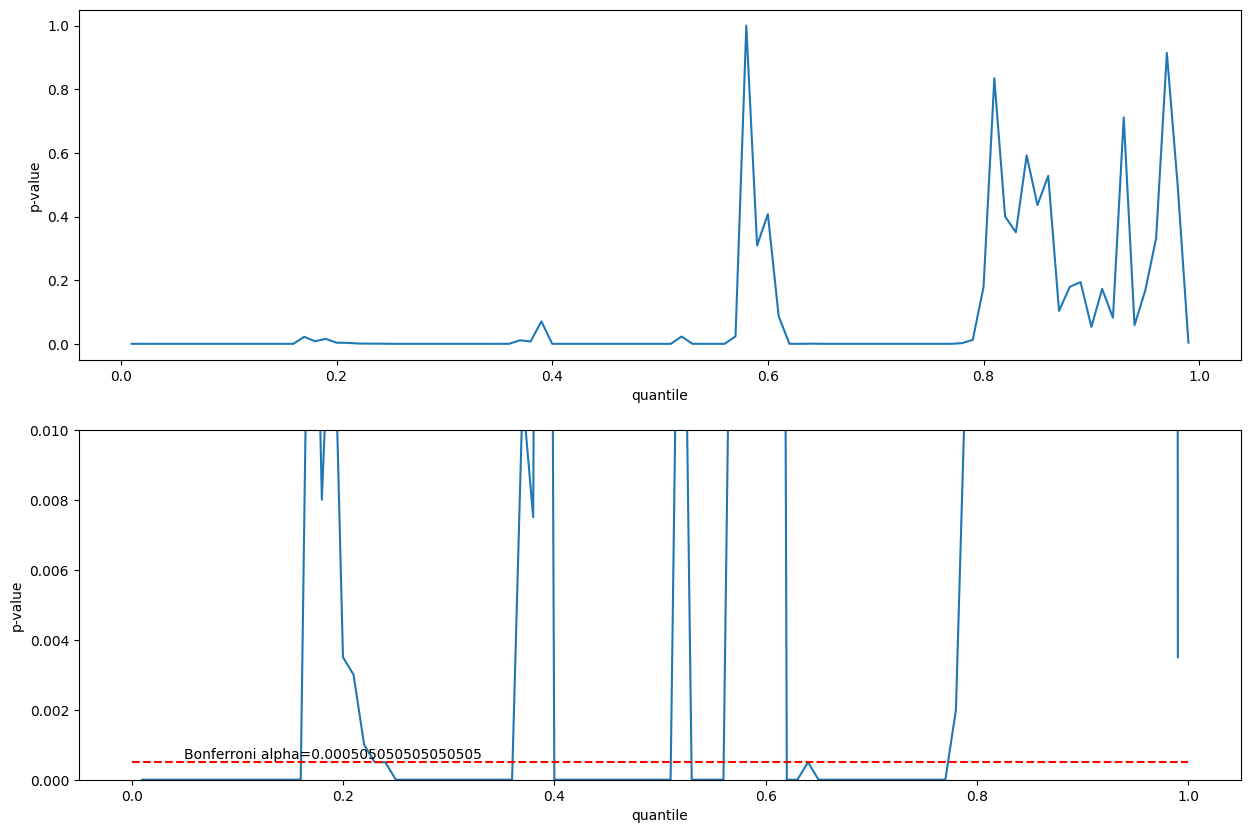

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
plot0 = sns.lineplot(x=result.keys(), y=[r['p_value'] for r in result.values()], ax=axes[0])
plot0.set(xlabel='quantile', ylabel='p-value')
plot1 = sns.lineplot(x=result.keys(), y=[r['p_value'] for r in result.values()], ax=axes[1])
plot1.set(xlabel='quantile', ylabel='p-value')
plot1.hlines(alpha, 0, 1, color='r',linestyle='--')
plot1.text(0.05, alpha+0.0001, f'Bonferroni alpha={alpha}')
plot1.set_ylim(0, 0.01);

In [ ]:
min([str(q) if result[q]['p_value'] < alpha else 'not found' for q in sorted(result.keys())])

'0.01'

## Задание 3. Децильный анализ (2/4) ##
Какой абсолютный наблюдаемый эффект находит при проверке бутстрапом на этом квантиле из симуляции проведенной выше?

Нужно указать среднюю разницу между квантилями по всем иттерациям бутстрапа. Введите ответ в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
q = 0.01
result[q]['resampled_diffs'].mean()

-15.001

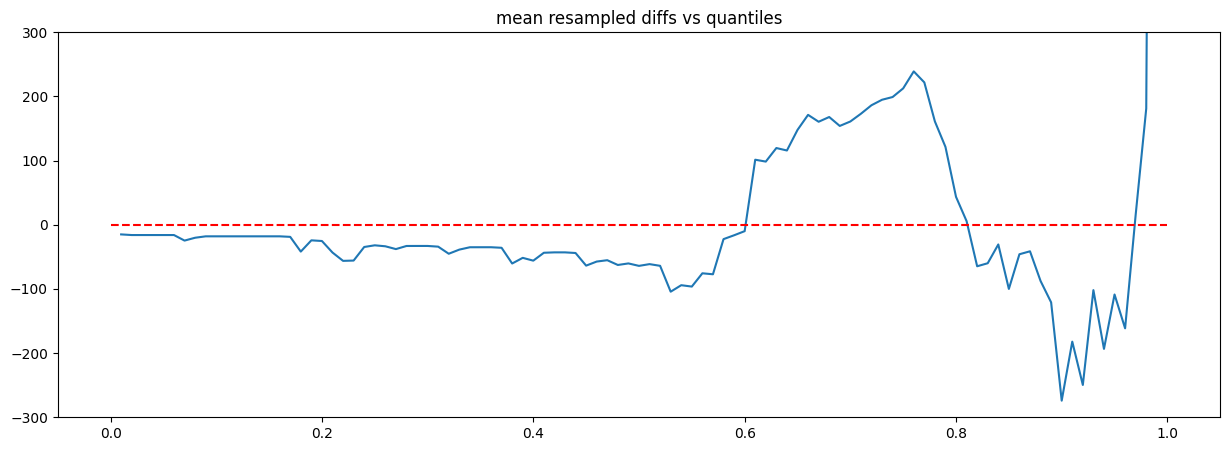

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5))
plot = sns.lineplot(x=result.keys(), y=[np.mean(r['resampled_diffs']) for r in result.values()])
plt.ylim(-300,300)
plt.hlines(0, 0, 1, color='r',linestyle='--')
plt.title('mean resampled diffs vs quantiles');

## Задание 3. Децильный анализ(3/4) ##
С какого перцентиля мы первый раз начинаем ловить положительный эффект между квантилями (квантиль группа 1 > квантиля группы 0)

Введите ответ в поле ниже с точностью до двух знаков в десятичной части.

In [ ]:
min([str(q) if np.mean(result[q]['resampled_diffs']) > 0 else 'not found' for q in list(result.keys())])

'0.61'

In [ ]:
diffs = [np.mean(result[q]['resampled_diffs']) for q in sorted(result.keys())]
pvals = [result[q]['p_value'] < alpha for q in sorted(result.keys())]
q = 0.01
for d, p in zip(diffs, pvals):
  if d > 0 and p:
    print(f"Статзначимая положительная разница между group 1 и group 2 начинает проявляться с {q:.2f} квантиля")
    print(f"Абсолютный наблюдаемый эффект {d:.1f}")
    break
  q += 0.01


Статзначимая положительная разница между group 1 и group 2 начинает проявляться с 0.62 квантиля
Абсолютный наблюдаемый эффект 98.5


## Задание 3. Децильный анализ (4/4) ##
Какой абсолютный наблюдаемый эффект находится при проверке бутстрапом на квантиле из симуляции, проведенной в предыдущем задании?

Нужно указать среднюю разницу между квантилями по всем итерациям бутстрапа. Введите ответ в поле ниже с точностью до одного знака в десятичной части.

Как мы видим бутстрап помогает тестировать более сложные гипотезы, например о квантилях распределения. С его помощью мы может производить поиск по всем децилям распределения. В конкретном кейсе это помогло найти области в которых цена отработала в сторону снижения ARPPU, и что более важно области в которых изменение цен увеличило ARPPU.

Скорее всего после этого анализа менеджер захочет менять цены сегментационно, а не всем сразу. Это позволит расти по выручке за счет тех, у кого менее эластичная реакция на рост цен, и не трогать более эластичный спрос.

In [ ]:
# функция, возвращающая resample выборок resample_num раз
def get_resampled_data(sample, sample_size, resample_num):
    resampled_data = np.random.choice(sample, size = (resample_num, sample_size), replace=True)
    return(resampled_data)

# функция, которая достает квантили из resample выборок
def get_resampled_quantile(resampled_data, q=0.5):
    resampled_stats = np.quantile(resampled_data, q=q, axis = 1)
    return(resampled_stats)

def bootstrap_ab_test(sample_data_A, sample_data_B, stat, resample_num, alpha, q):
    '''
    sample_data_A - значения в выборке А
    sample_data_B - значения в выборке B
    stat - можно передать оцениваемую функцию
    resample_num - количество итераций извлечения resample выборок в бутстрапе
    alpha - уровень значимости при проверке
    q - указывается если вы оцениваете определенный квантиль распределения

    '''
    # получаем бутстрапированные данные
    resampled_data_A = get_resampled_data(sample_data_A, len(sample_data_A), resample_num)
    resampled_data_B = get_resampled_data(sample_data_B, len(sample_data_B), resample_num)

    if q is not None:
        resampled_stats_A = get_resampled_quantile(resampled_data_A, q)
        resampled_stats_B = get_resampled_quantile(resampled_data_B, q)
    else:
        resampled_stats_A = get_resampled_stats(resampled_data_A, stat)
        resampled_stats_B = get_resampled_stats(resampled_data_B, stat)

    # рассчитываем разницу для статистики
    resampled_diffs = resampled_stats_B - resampled_stats_A

    # рассчитываем перцентильный бутстрап
    perc_ci = np.quantile(resampled_diffs, [alpha/2, 1-alpha/2])

    if q is not None:
        samples_diff = np.quantile(sample_data_B, q) - np.quantile(sample_data_A, q)
    else:
        samples_diff = stat(sample_data_B) - stat(sample_data_A)

    # рассчитываем p-value
    adjusted_resampled_diffs = resampled_diffs - samples_diff
    false_positive_count = np.sum(np.abs(adjusted_resampled_diffs) >= np.abs(samples_diff))
    p_value = false_positive_count / resample_num

    # формируем результат
    boot_data_object = {'resample_stats_A':resampled_stats_A,
                         'resample_stats_B':resampled_stats_B,
                         'resampled_diffs': resampled_diffs,
                         'conf_int': perc_ci,
                         'stat_diffs_std': resampled_diffs.std(),
                         'p_value': p_value}
    return(boot_data_object)

# также сделаем функцию, отрисовывающую результат проверки гипотез через бутстрап
def boot_data_plot(boot_data_object, alpha):
    fig, axes = plt.subplots(1, 2, figsize = (15,6))

    axes[0].set_title('A & B botstraped stats distribution')
    sns.kdeplot(ax = axes[0], data = boot_data_object['resample_stats_A'], label = "resample_stats_A", color = 'blue')
    axes[0].axvline(x = boot_data_object['resample_stats_A'].mean(), linestyle = '--', color = 'blue')
    sns.kdeplot(ax = axes[0], data = boot_data_object['resample_stats_B'], label = "resample_stats_B", color = 'red')
    axes[0].axvline(x = boot_data_object['resample_stats_B'].mean(), linestyle = '--', color = 'red')
    axes[0].legend(loc='upper right')

    axes[1].set_title('A & B botstraped stats diffs distribution')
    sns.kdeplot(ax=axes[1], data = boot_data_object['resampled_diffs'], label = "resample_stats_diffs", color = 'black')
    axes[1].axvline(x = 0, color = 'red')
    axes[1].axvline(x = boot_data_object['resampled_diffs'].mean(), linestyle = '--', color = 'black')
    axes[1].vlines(boot_data_object['conf_int'], ymin = 0, ymax= 0.05, linestyle = '-', color = 'black')
    axes[1].legend(loc='upper right')

    # сделаем часть, которая принтует основные значения и вывод по проверке гипотез
    if boot_data_object['p_value'] < alpha:
        conclusion = 'H0 rejected!!!'
    else:
        conclusion = "H0 doesn't rejected!!!"

    print(conclusion)
    print('A sample stat mean =', boot_data_object['resample_stats_A'].mean())
    print('B sample stat mean =', boot_data_object['resample_stats_B'].mean())
    print('Avg lift =', boot_data_object['resampled_diffs'].mean())
    print('p-val =', boot_data_object['p_value'])
    print('Diffs ci:', boot_data_object['conf_int'])
    print('stats diffs std = ', boot_data_object['stat_diffs_std'])


  0%|          | 0/99 [00:00<?, ?it/s]

Target percentile =  0.01


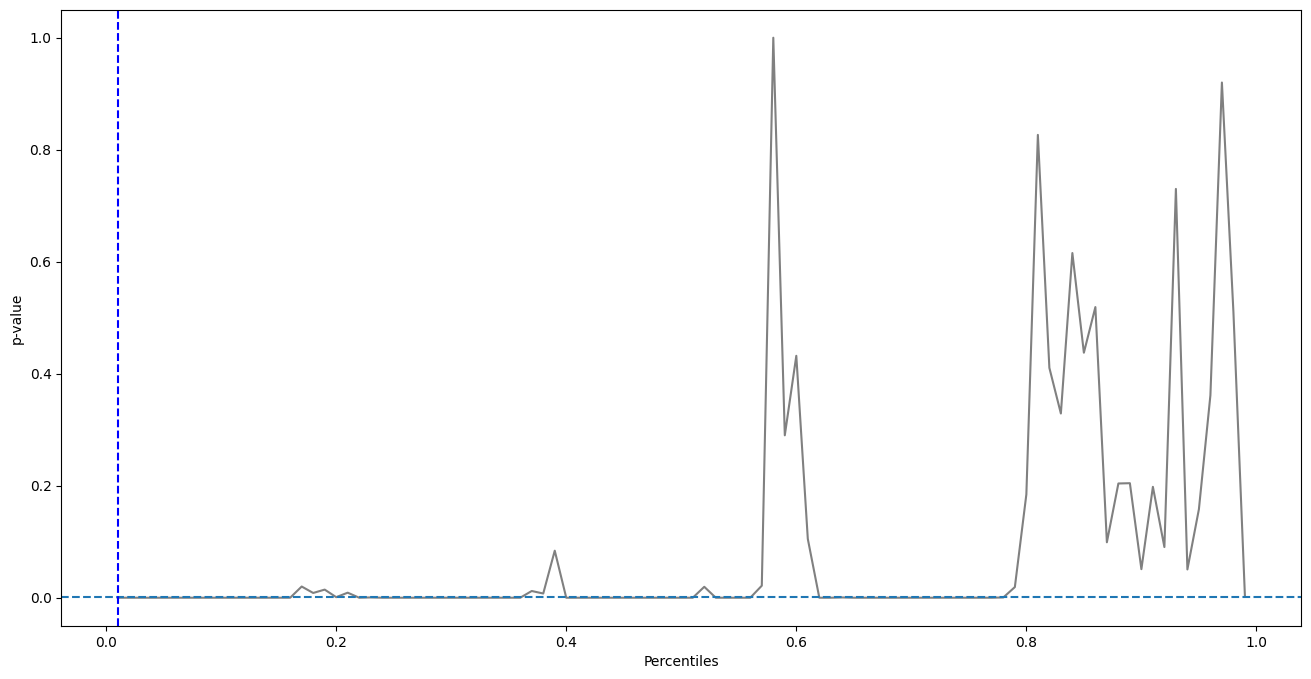

In [ ]:
perc_linspace = np.arange(start = 0.01, stop = 1, step = 0.01) # создаем массив квантиле по которым мы будем проверять гипотезу о равенстве квантиля

sample_1 = sample_data_B = b
sample_data_A = a
p_val_list = []
diffs_list = []
lower_ci_list = []
upper_ci_list = []

# для каждого определяемого квантиля проверяем гипотезу о равенстве квантилей с помощью бутстрапа
np.random.seed(1)
for i in tqdm(perc_linspace):
    boot_data = bootstrap_ab_test(sample_data_A,
                  sample_data_B = sample_1,
                  stat = np.mean,
                  resample_num = 2000,
                  alpha = (0.05/len(perc_linspace)), q = i) # не забываем штрафовать нашу альфа. Пока используем самый простой и страшный Бонферрони
    p_val_list.append(boot_data['p_value'])
    diffs_list.append(boot_data['resampled_diffs'].mean())
    lower_ci_list.append(boot_data['conf_int'][0])
    upper_ci_list.append(boot_data['conf_int'][1])
p_val_list = np.array(p_val_list)
diffs_list = np.array(diffs_list)
lower_ci_list = np.array(lower_ci_list)
upper_ci_list = np.array(upper_ci_list)

plt.figure(figsize=(16,8))
sns.lineplot(x = np.round(perc_linspace,2), y = p_val_list, color= 'gray')
plt.xlabel("Percentiles")
plt.ylabel("p-value")
plt.axhline(y = (0.05/len(perc_linspace)), linestyle = '--')
target_percentile = perc_linspace[p_val_list <= (0.05/len(perc_linspace))].min()
plt.axvline(target_percentile, linestyle = '--', color = 'blue')
print('Target percentile = ', perc_linspace[p_val_list <= (0.05/len(perc_linspace))].min())


In [ ]:
diffs_list

array([ -15.001   ,  -16.      ,  -16.      ,  -16.      ,  -16.      ,
        -16.      ,  -24.49334 ,  -20.18152 ,  -18.0075  ,  -18.      ,
        -18.      ,  -18.      ,  -18.      ,  -18.      ,  -18.      ,
        -18.      ,  -18.824115,  -41.83432 ,  -24.30055 ,  -25.358   ,
        -42.927925,  -56.3289  ,  -55.81735 ,  -34.7327  ,  -32.      ,
        -33.57279 ,  -37.741715,  -33.03    ,  -33.      ,  -33.      ,
        -34.354605,  -45.31462 ,  -38.5137  ,  -35.0333  ,  -35.      ,
        -35.      ,  -36.20799 ,  -60.10649 ,  -52.28587 ,  -56.3449  ,
        -43.7362  ,  -43.      ,  -43.      ,  -44.0629  ,  -64.4415  ,
        -57.7017  ,  -55.02059 ,  -62.75034 ,  -60.82217 ,  -63.92875 ,
        -61.6763  ,  -64.26366 , -104.25651 ,  -95.02251 ,  -96.816025,
        -75.83866 ,  -77.385425,  -22.68006 ,  -16.110125,  -11.9666  ,
         98.39262 ,   97.69185 ,  118.850165,  116.15348 ,  147.779125,
        171.12215 ,  160.724075,  167.69694 ,  153.33813 ,  160.

In [ ]:
np.array(diffs)

array([ -15.001   ,  -16.      ,  -16.      ,  -16.      ,  -16.      ,
        -16.006   ,  -24.64034 ,  -20.2116  ,  -18.012   ,  -18.      ,
        -18.      ,  -18.      ,  -18.      ,  -18.      ,  -18.      ,
        -18.      ,  -18.83109 ,  -41.80304 ,  -24.2485  ,  -25.288   ,
        -43.255925,  -56.2389  ,  -55.7724  ,  -34.6164  ,  -32.      ,
        -33.5211  ,  -37.89129 ,  -33.044   ,  -33.      ,  -33.      ,
        -34.09285 ,  -45.14036 ,  -38.708005,  -35.0318  ,  -35.      ,
        -35.      ,  -35.85095 ,  -60.3562  ,  -51.540045,  -55.9059  ,
        -43.6082  ,  -43.      ,  -43.      ,  -43.9916  ,  -63.672625,
        -57.31793 ,  -55.21754 ,  -62.64088 ,  -60.23187 ,  -64.04025 ,
        -61.322635,  -63.96576 , -104.28056 ,  -94.15988 ,  -96.312325,
        -75.61266 ,  -77.135   ,  -22.361   ,  -16.363   ,   -9.944   ,
        101.39401 ,   98.46786 ,  119.602585,  115.76416 ,  147.8063  ,
        171.29    ,  160.560475,  167.9537  ,  154.03439 ,  160.

In [ ]:
len(a)

15994

In [ ]:
len(b)

16121